In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
%matplotlib inline

from sklearn import linear_model
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

c:\users\bretw\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


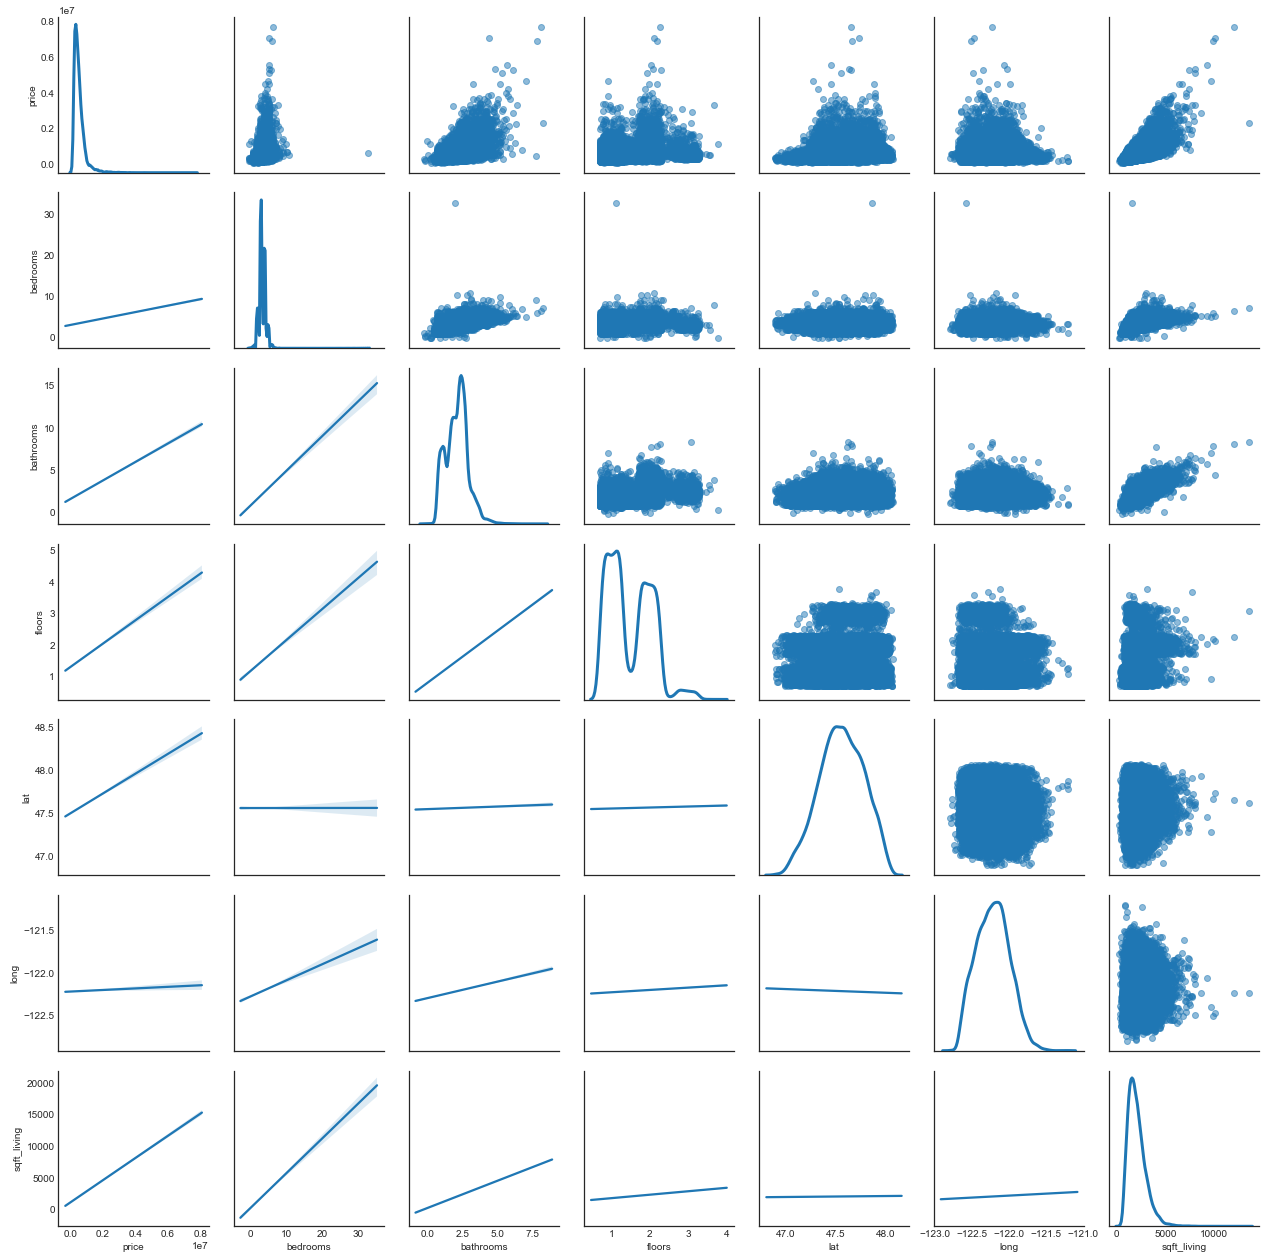

In [2]:
df = pd.read_csv('..\\home_data.csv')

# Reduce the original data as per assignment requirements to 1 outcome (price),
# and 5 variables (2 categorical: bedrooms, floors).
df_explore = df.loc[:, ['waterfront', 'price', 'bedrooms','bathrooms', 'floors', 'lat', 'long', 'sqft_living']]

# I don't know which plot styles are nicest, so I'll use one from the course notes
sns.set_style('white')

# We will add jitter to all variables, then do a PairGrid.
df_jittered = df_explore.loc[:, 'price':'sqft_living'].dropna()
# Adding random noise.
jitter = pd.DataFrame(
np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)
# Combine the data and the noise.
df_jittered = df_jittered.add(jitter)

# Here is where we declare we are making a scatter plot matrix.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
# Scatterplot.
g.map_upper(plt.scatter, alpha=.5)
# Fit a line showing linear relationship between varaibles.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
# Give info about the univariate distribution of each variable.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

                price  bedrooms  bathrooms    floors       lat      long  \
price        1.000000  0.308350   0.525138  0.256794  0.307003  0.021626   
bedrooms     0.308350  1.000000   0.515884  0.175429 -0.008931  0.129473   
bathrooms    0.525138  0.515884   1.000000  0.500653  0.024573  0.223042   
floors       0.256794  0.175429   0.500653  1.000000  0.049614  0.125419   
lat          0.307003 -0.008931   0.024573  0.049614  1.000000 -0.135512   
long         0.021626  0.129473   0.223042  0.125419 -0.135512  1.000000   
sqft_living  0.702035  0.576671   0.754665  0.353949  0.052529  0.240223   

             sqft_living  
price           0.702035  
bedrooms        0.576671  
bathrooms       0.754665  
floors          0.353949  
lat             0.052529  
long            0.240223  
sqft_living     1.000000  


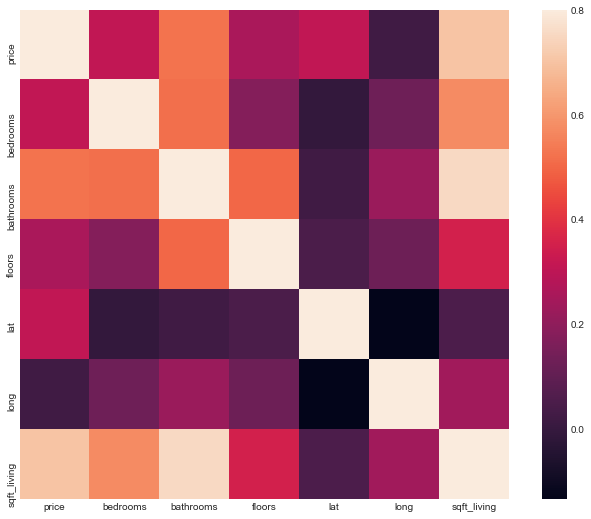

In [3]:
# Next, we'll make a correlation matrix.
corrmat = df_explore.loc[:, 'price':'sqft_living'].corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12,9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

I wish that the correlation matrix had turned out blue to red, like in the course notes, but for some reason this is what I got. As we can see, the outcome varaible (price) and sqft_living have the highest correlation among all variables. I believe this is a good thing and will help make a pretty accurate model. 

However, the next highest correlation is between sqft_living and no. of bedrooms. When we do PCA, this might be a bad thing because the two variables will probably get combined, and we will lose some information from our strongest indicator of price, the square footage. It might be a good idea to drop the rooms varaible, but I'll definitely ask my mentor before I do that.

Edit: I added in the no. of bathrooms, and I have the same concern because it correlates even higher to square footage!

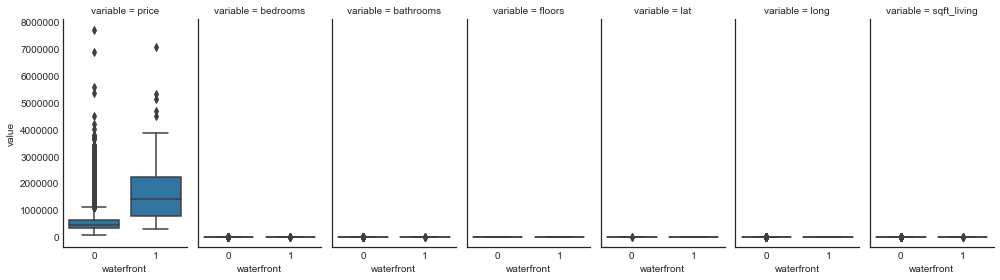

           bathrooms                                                   \
               count      mean       std   min  25%   50%   75%   max   
waterfront                                                              
0            21450.0  2.110478  0.765648  0.00  1.5  2.25  2.50  8.00   
1              163.0  2.677914  1.092456  0.75  2.0  2.50  3.25  6.75   

           bedrooms             ...         price            sqft_living  \
              count      mean   ...           75%        max       count   
waterfront                      ...                                        
0           21450.0  3.371375   ...      639897.0  7700000.0     21450.0   
1             163.0  3.300613   ...     2215000.0  7062500.0       163.0   

                                                                              
                   mean          std    min     25%     50%     75%      max  
waterfront                                                                    
0           2071

In [4]:
# We only have one categorical variable, and that is waterfront. We will make a boxplot for each continuous variable.

# Restructure the data so we can use FacetGrid rather than making a boxplot
# for each variable separately.
df_long = df_explore
df_long = pd.melt(df_long, id_vars=['waterfront'])

g = sns.FacetGrid(df_long, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "waterfront", "value")
plt.show()

# Descriptive statistics by group.
print(df_explore.groupby('waterfront').describe())

# Test whether group differences are significant.
for col in df_explore.loc[:,'price':'sqft_living'].columns:
    print(col)
    print(stats.ttest_ind(
        df_explore[df_explore['waterfront'] == 0][col].dropna(),
        df_explore[df_explore['waterfront'] == 1][col].dropna()
    ))

I will come back to the box plot scaling issue. Is there a way to give each their own y-axis? Or do I need to normalize before I can explore my data?

The t-tests still work! It appears that the effect of waterfront has statistically insignificant effect on the number of bathrooms in a house. I find this a little peculiar, since the number of rooms in a house is different for waterfront vs non-waterfront homes. Shouldn't there be more or less bathrooms if there are more or less bedrooms?

# Let's Make Some Features!

In [5]:
# First, let's have the head nearby for feautre engineering
df_explore.head()

,waterfront,price,bedrooms,bathrooms,floors,lat,long,sqft_living
0,0,221900,3,1.00,1.0,47.5112,-122.257,1180
1,0,538000,3,2.25,2.0,47.7210,-122.319,2570
2,0,180000,2,1.00,1.0,47.7379,-122.233,770
3,0,604000,4,3.00,1.0,47.5208,-122.393,1960
4,0,510000,3,2.00,1.0,47.6168,-122.045,1680


In [6]:
# First feature: I think we can round up the number of bathrooms in a house, 
# and the new feaure will be the number of toilets.
df_features = pd.DataFrame()
df_features['toilets'] = df_explore.bathrooms.apply(lambda x: math.ceil(x))

# Second feature: let's take the square root of the square footage. We will quasi-assume each property is
# square, and this feature will give us side length
df_features['side_length'] = df_explore.sqft_living.apply(lambda x: x**(0.5))

# Third feature: Square footage per bathroom. Why not?
df_features['sqft_bath'] = df_explore.sqft_living.div(df_explore.bathrooms)
df_features['sqft_bath'] = np.where(df_features.sqft_bath>10**20, np.nan, df_features.sqft_bath)

# Fourth feature: Similar to above, let's make a square footage per bedroom as well
df_features['sqft_bed'] = df_explore.sqft_living.div(df_explore.bedrooms)
df_features['sqft_bed'] = np.where(df_features.sqft_bed>10**20, np.nan, df_features.sqft_bed)

# Fifth feature: If we add up the bathrooms, bedrooms, and add 2 for a living room and kitchen,
# we would have the total_rooms
df_features['total_rooms'] = df_explore.bedrooms.add(df_explore.bathrooms) + 2

# Sixth feature: The distance to geographic center of Seattle can be approximated
# by treating the lat and long coordinates as cartesian coordinates, since this data
# is over a relatively small distance. However, the distance between longitude lines at
# a latitude of 45 degrees is ~0.707 times the distance between latitude lines.
lat_center = 47.6223
lon_center = -122.3522
df_features['from_center'] = np.sqrt((df_explore.lat - lat_center)**2 + 
                                     ((df_explore.long - lon_center)*0.707)**2)

# Seventh feature: Similar to above, I want to see if the directional distance
# from the center has an effect. Again, assume the degrees are proportional to cartesian distances
df_features['lat_from_center'] = df_explore.lat - lat_center

# Eighth feature: See above
df_features['lat_from_center'] = (df_explore.long - lon_center)*0.707

# Ninth feature: I think that the square footage may not have a linear effect on price.
# We already square rooted it, so let's square it now
df_features['quad_footage'] = df_explore.sqft_living**2

# Tenth feature: Similar to feature 9 above, let's do the same with bedrooms
df_features['sq_bedrooms'] = df_explore.bedrooms**2

# Now I will add all of the original features back into our analysis
df_features['waterfront'] = df_explore['waterfront']
df_features['price'] = df_explore['price']
df_features['bedrooms'] = df_explore['bedrooms']
df_features['bathrooms'] = df_explore['bathrooms']
df_features['floors'] = df_explore['floors']
df_features['lat'] = df_explore['lat']
df_features['long'] = df_explore['long']
df_features['sqft_living'] = df_explore['sqft_living']

df_features.dropna(axis=0, inplace=True)

df_features.head(n=7)

,toilets,side_length,sqft_bath,sqft_bed,total_rooms,from_center,lat_from_center,quad_footage,sq_bedrooms,waterfront,price,bedrooms,bathrooms,floors,lat,long,sqft_living
0,1,34.351128,1180.000000,393.333333,6.00,0.129898,0.067306,1392400,9,0,221900,3,1.00,1.0,47.5112,-122.257,1180
1,3,50.695167,1142.222222,856.666667,7.25,0.101453,0.023472,6604900,9,0,538000,3,2.25,2.0,47.7210,-122.319,2570
2,1,27.748874,770.000000,385.000000,5.00,0.143058,0.084274,592900,4,0,180000,2,1.00,1.0,47.7379,-122.233,770
3,3,44.271887,653.333333,490.000000,9.00,0.105519,-0.028846,3841600,16,0,604000,4,3.00,1.0,47.5208,-122.393,1960
4,2,40.987803,840.000000,560.000000,7.00,0.217260,0.217190,2822400,9,0,510000,3,2.00,1.0,47.6168,-122.045,1680
5,5,73.620649,1204.444444,1355.000000,10.50,0.247787,0.245470,29376400,16,0,1225000,4,4.50,1.0,47.6561,-122.005,5420
6,3,41.412558,762.222222,571.666667,7.25,0.313107,0.017816,2941225,9,0,257500,3,2.25,2.0,47.3097,-122.327,1715


# New for 3.1.4 Project

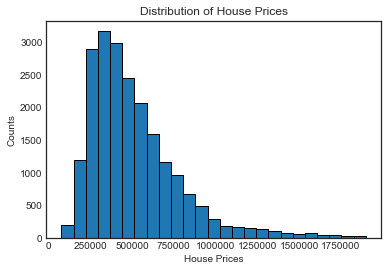

In [7]:
plt.hist(df_features[df_features['price'] < 1900000]['price'], bins=25, edgecolor='black')
plt.title('Distribution of House Prices')
plt.xlabel('House Prices')
plt.ylabel('Counts')
plt.show()

In [8]:
# To categorize price into cheap, medium, and expensive, I will split the data into three equal groups.
# Is this the best way to do that? Probably not, but we are building a logistic regression algo, not
# a data segmentation algo. This should suffice.
y = pd.qcut(df_features.price, 3, labels=["Low", "Medium", "High"])
y.value_counts()

Medium    7221
Low       7214
High      7162
Name: price, dtype: int64

In [22]:
from sklearn.metrics import confusion_matrix

# Sweeeeet. That worked nicely. Next, we will create our X variable and pick n_components from a PCA analysis
X = df_features.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

vanilla_lr = linear_model.LogisticRegression(C=10**42) # C ~= +infinity, lambda ~= 0.000000, no regularization
vanilla_lr.fit(X_train, y_train)
vanilla_lr.score(X_test, y_test)

0.54097222222222219

In [33]:
lambdas = np.arange(.00001, .005, .0005)
ridge_scores = []
for lambd in lambdas:
    ridge_lr = linear_model.LogisticRegression(penalty='l2', C=1/lambd)
    ridge_lr.fit(X_train, y_train)
#     ridge_scores.append(cross_val_score(ridge_lr, X_train, y_train, cv=5).mean())
    ridge_scores.append(ridge_lr.score(X_test, y_test))

In [31]:
las_lambdas = np.arange(.0001, .01, .0005)
lasso_scores = []
for lambd in las_lambdas:
    lasso_lr = linear_model.LogisticRegression(penalty='l1', C=1/(lambd))
    lasso_lr.fit(X_train, y_train)
    lasso_scores.append(cross_val_score(lasso_lr, X_train, y_train, cv=5).mean())
#     lasso_scores.append(lasso_lr.score(X_test, y_test))

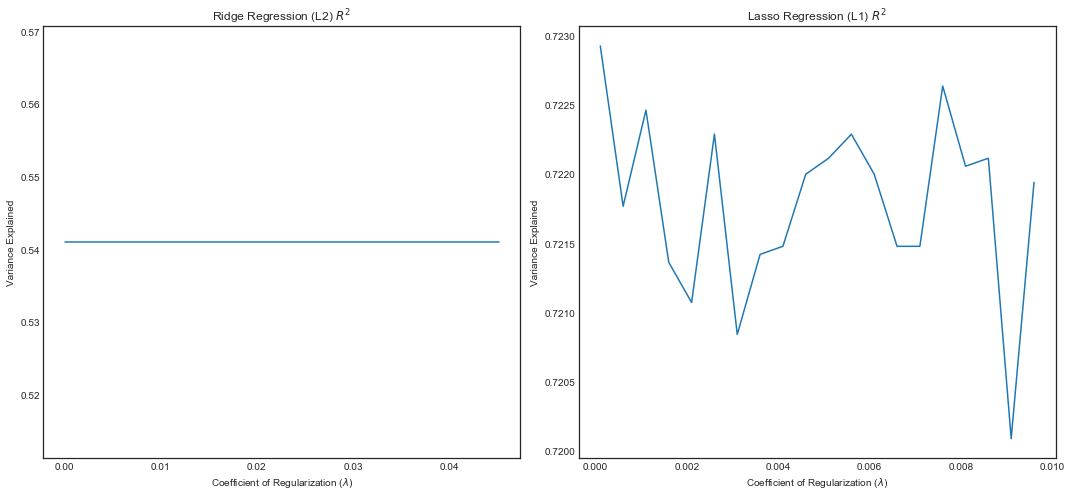

In [32]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.title('Ridge Regression (L2) $R^2$')
plt.xlabel('Coefficient of Regularization ($\lambda$)')
plt.ylabel('Variance Explained')
plt.plot(lambdas*10, ridge_scores, label='Ridge')

plt.subplot(122)
plt.title('Lasso Regression (L1) $R^2$')
plt.xlabel('Coefficient of Regularization ($\lambda$)')
plt.ylabel('Variance Explained')
plt.plot(las_lambdas, lasso_scores, label='Lass')

plt.tight_layout()
plt.show()

It seems that l1 regularization does pretty well on this dataset, much better than the vanilla logistic regression. However, I did notice that both the vanilla and ridge logistic regression gave the same value everytime, no matter the value of lambda. I tried a range of lambdas from $10e^-5$ to $10e^+5$, but still could not get that damn line to diverge on the left plot. I think there must be something about my data that is too powerfully biased to get anything better. 

The L1 regression is not free from its problems either, however. It remains pretty jagged and random for all ranges of lambda that I've tried, which makes it pretty difficult to select which lambda I would want to use.